In [1]:
''' IMPORTS '''
import math
import numpy as np
import random
from numpy.random import beta as Beta
from matplotlib import pyplot as plt
import pandas as pd
from JudgingSimulator import JudgingSimulator

Text(0.5, 0, 'q-values')

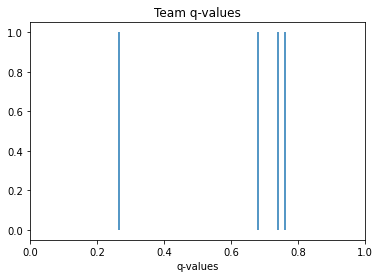

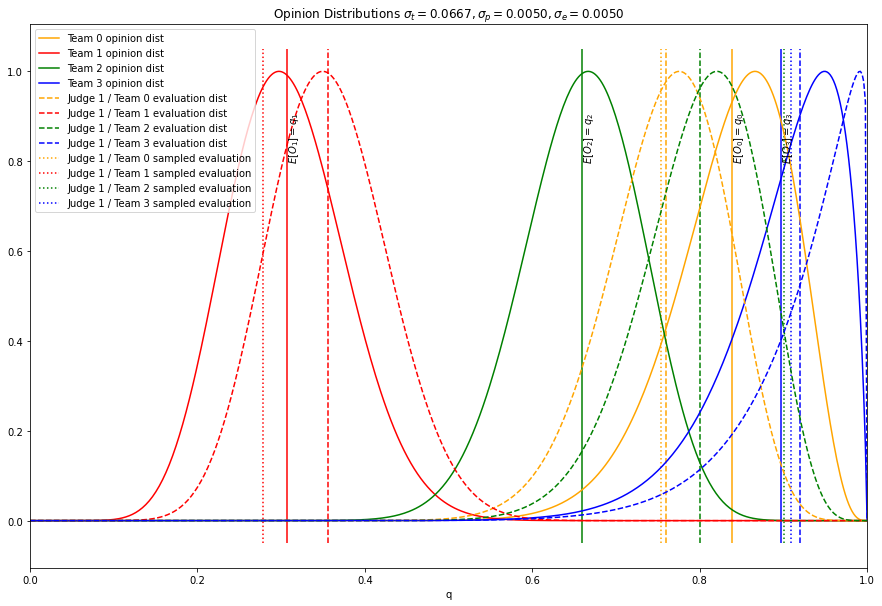

In [34]:
import scipy.stats as ss
def minmaxscaler(xs):
    return (xs - xs.min()) / (xs.max() - xs.min())

plt.figure(figsize=(15, 10))

def get_qvalues(var_team, n_teams):
    a = 1 - np.sqrt(12 * var_team)
    return np.random.uniform(a, 0.9, n_teams)

var_team = 1/15
qs = get_qvalues(var_team = var_team, n_teams = 4)
# plt.vlines(qs, 0, 1)
# plt.xlim(0, 1)
# plt.title('Team q-values')
# plt.xlabel('q-values')

def plot_beta(a=2, b=2, **kwargs):
    x = np.linspace(0, 1, 500)
    y = ss.beta.pdf(x, a, b)
    plt.plot(x, minmaxscaler(y), **kwargs)

opinion_var=0.005
eval_var=0.005
sim = JudgingSimulator(qs, n_judges=1, opinion_var=opinion_var, eval_var=eval_var)

colors = ['orange', 'red', 'green', 'blue']

for i, (a, b) in enumerate(sim.team_value_shapes):
    plot_beta(a, b, c=colors[i], label=f'Team {i} opinion dist')

ylims = plt.ylim()
plt.vlines(qs, *ylims, color=colors, linestyles='-')
plt.xlim(0, 1)
plt.title(f'Opinion Distributions $\sigma_t={var_team:.4f}, \sigma_p={opinion_var:.4f}, \sigma_e={eval_var:.4f}$')
plt.xlabel('q')

for i, q in enumerate(qs):
    plt.text(q, plt.ylim()[1]-.3, f'$E[O_{i}]=q_{i}$', rotation=90)

for judge_opinions in sim.judges_opinions:
    plt.vlines(judge_opinions, *ylims, color=colors, linestyles='--')
    
for i, opinion in enumerate(judge_opinions):
    a, b = sim.get_shape_params(opinion, sim.eval_var)
    plot_beta(a, b, c=colors[i], linestyle='--', label=f'Judge 1 / Team {i} evaluation dist')

evals = sim.sample_evaluations(0)
for i, eval in enumerate(evals):
    plt.vlines(eval, *ylims, color=colors[i], linestyles='dotted', label=f'Judge 1 / Team {i} sampled evaluation')

plt.legend()

In [ ]:
# opinion_dist = np.array([[Beta(*value_shape) for value_shape in sim.team_value_shapes] for _ in range(1000)])
# df = pd.DataFrame(opinion_dist).rename_axis("team", axis="columns").rename_axis("idx", axis="index")
# df = df.stack().reset_index(level=[0,1]).rename(columns={0: 'q'})

# # Changing orientation
# dx="team"; dy="q"; ort="v"; pal = "Set2"; sigma = .2
# f, ax = plt.subplots(figsize=(14, 10))

# pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
#                  width_viol = .5, ax = ax, orient = ort)


Text(0.5, 1.0, 'RBO Effect of Parameter $p$')

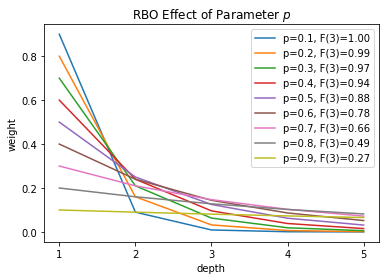

In [62]:
xs = np.arange(1, 6)
w = lambda p: (1 - p) * np.power(p, xs-1)

for p in np.linspace(0.1, 0.9, 9):
    plt.plot(xs, w(p), label=f'p={p:.1f}, F(3)={sum(w(p)[:3]):.2f}')

plt.legend()

plt.xticks(xs)
plt.ylabel('weight')
plt.xlabel('depth')
plt.title('RBO Effect of Parameter $p$')